In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# additional import
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import to_categorical
import time
from tensorflow.keras import datasets, layers, models

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [3]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [ ]:
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


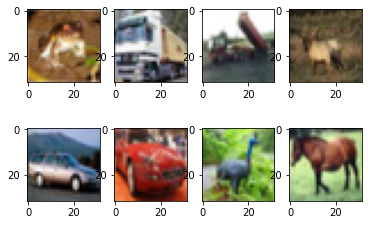

In [4]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [5]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [6]:
target_vec.shape, feature_mtx.shape
np.histogram(imgs[1][:,:,0],bins=bins)[0]

array([ 98, 301, 233, 224, 168], dtype=int64)

In [7]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [8]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [9]:
noisy_imgs = np.empty((n_noisy,32,32,3))
for i in range(n_noisy):
    img_fn = f'../data/images/{10000+i+1:05d}.png'
    noisy_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
noisy_target_vec = np.empty(n_noisy)
i = 0
for i in range(n_noisy):
    noisy_target_vec[i] = noisy_labels[10000+i]
x_train = tf.cast(noisy_imgs, dtype='float32')/255.0
y_train = tf.one_hot(noisy_target_vec, depth=10)


################### for later prediction
clean_imgs = np.empty((n_clean_noisy,32,32,3))
for i in range(n_clean_noisy):
    img_fn = f'../data/images/{i+1:05d}.png'
    clean_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
clean_target_vec = np.empty(n_clean_noisy)
i = 0
for i in range(n_clean_noisy):
    clean_target_vec[i] = clean_labels[i]
x_test = tf.cast(clean_imgs, dtype='float32')/255.0
y_test = tf.one_hot(clean_target_vec, depth=10)    
#################

In [10]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

    
model1 = tf.keras.Sequential([
    # feature extraction(convolution)
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    
    # classification(nn)
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax") #normalize probability
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction="auto"),
              metrics=["accuracy"]
              )

start = time.time()
model1.fit(x_train, y_train, epochs = 1, validation_split=0.3)
end = time.time()


# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
# start = time.time()
# history = model1.fit(x_train, y_train, batch_size=700, epochs=100, validation_split=0.3, 
#           callbacks=early_stopping)
# end = time.time()

875/875 [==============================] - 25s 28ms/step - loss: 2.2822 - accuracy: 0.1372 - val_loss: 2.2525 - val_accuracy: 0.1708


In [11]:
y_train = noisy_target_vec.astype(int)
x_train = noisy_imgs/255.0
x_train  = x_train.astype(float)

In [12]:
from sklearn.model_selection import KFold
CV = KFold(n_splits = 5)
CV

def get_score(model, X_train, X_val, Y_train, Y_val):
    return model.fit(X_train, Y_train, epochs = 2)
#     return model.score(X_val, Y_val)

for train_index, val_index in CV.split(x_train):
    X_train, X_val, Y_train, Y_val = x_train[train_index], x_train[val_index], y_train[train_index], y_train[val_index]
    
    X_train = tf.cast(X_train, dtype='float32')/255.0
    X_val = tf.cast(X_val, dtype='float32')/255.0
    Y_train = tf.one_hot(Y_train, depth=10)
    Y_val = tf.one_hot(Y_val, depth=10)

    print(get_score(model1, X_train, X_val, Y_train, Y_val))


Epoch 1/2
1000/1000 [==============================] - 22s 22ms/step - loss: 2.3034 - accuracy: 0.1009
Epoch 2/2
1000/1000 [==============================] - 22s 22ms/step - loss: 2.3029 - accuracy: 0.1004
Epoch 1/2
1000/1000 [==============================] - 22s 22ms/step - loss: 2.3026 - accuracy: 0.1018
Epoch 2/2
1000/1000 [==============================] - 20s 20ms/step - loss: 2.3026 - accuracy: 0.1007
Epoch 1/2
1000/1000 [==============================] - 21s 21ms/step - loss: 2.3027 - accuracy: 0.1002
Epoch 2/2
1000/1000 [==============================] - 20s 20ms/step - loss: 2.3027 - accuracy: 0.1005
Epoch 1/2
1000/1000 [==============================] - 20s 20ms/step - loss: 2.3026 - accuracy: 0.1021
Epoch 2/2
1000/1000 [==============================] - 20s 20ms/step - loss: 2.3026 - accuracy: 0.1016
Epoch 1/2
1000/1000 [==============================] - 20s 20ms/step - loss: 2.3027 - accuracy: 0.1017
Epoch 2/2
1000/1000 [==============================] - 20s 20ms/step - lo

In [14]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    
    image = tf.reshape(image, ((1,) + image.shape))
    predictions = model1.predict(image)
    
    return np.argmax(predictions)

### 2.3. Model II

label correction

In [60]:
# split train data

## first 7,000 images(clean labels)
clean_imgs = np.empty((n_clean_noisy,32,32,3))
for i in range(n_clean_noisy):
    img_fn = f'../data/images/{i+1:05d}.png'
    clean_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
clean_target_vec = np.empty(n_clean_noisy)
i = 0
for i in range(n_clean_noisy):
    clean_target_vec[i] = clean_labels[i]
x_train = tf.cast(clean_imgs, dtype='float32')/255.0
y_train = tf.one_hot(clean_target_vec, depth=10)   

x_train_7000 = x_train[:7_000]
y_train_7000 = y_train[:7_000]
x_test_3000 = x_train[7_000:]
y_test_3000 = y_train[7_000:]


## last 40.000 images
noisy_imgs = np.empty((n_noisy,32,32,3))
for i in range(n_noisy):
    img_fn = f'../data/images/{10000+i+1:05d}.png'
    noisy_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
noisy_target_vec = np.empty(n_noisy)
i = 0
for i in range(n_noisy):
    noisy_target_vec[i] = noisy_labels[10000+i]
x_test = tf.cast(noisy_imgs, dtype='float32')/255.0
y_test = tf.one_hot(noisy_target_vec, depth=10)

In [23]:
# Train the same CNN model with the first 7,000 images (clean labels)

model1 = tf.keras.Sequential([
    # feature extraction(convolution)
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    
    # classification(nn)
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax") #normalize probability
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction="auto"),
              metrics=["accuracy"]
              )

start = time.time()
model1.fit(x_train_7000, y_train_7000, epochs = 5)
end = time.time()


Epoch 1/5
219/219 [==============================] - 6s 23ms/step - loss: 1.9703 - accuracy: 0.2609
Epoch 2/5
219/219 [==============================] - 5s 22ms/step - loss: 1.6285 - accuracy: 0.3987
Epoch 3/5
219/219 [==============================] - 5s 22ms/step - loss: 1.4614 - accuracy: 0.4700
Epoch 4/5
219/219 [==============================] - 5s 23ms/step - loss: 1.3437 - accuracy: 0.5136
Epoch 5/5
219/219 [==============================] - 5s 24ms/step - loss: 1.2749 - accuracy: 0.5469


In [108]:
# Predict using this same model to get the labels for the last 40,000 images (cleanED labels)
# replace the predicted lables with original noisy labels for the last 40_000


new_y_test = np.zeros((40_000, 10))
new_label = np.argmax(model1.predict(x_test), axis = 1)

for i in range(40_000):
    new_y_test[i, new_label[i]] = 1
    
new_y_test = tf.convert_to_tensor(new_y_test)
new_y_test.shape

TensorShape([40000, 10])

Model Training 

In [110]:
# Re-train model on last 40,000 images with new_y_test

noisy_imgs = np.empty((n_noisy,32,32,3))
for i in range(n_noisy):
    img_fn = f'../data/images/{10000+i+1:05d}.png'
    noisy_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
noisy_target_vec = np.empty(n_noisy)
i = 0
for i in range(n_noisy):
    noisy_target_vec[i] = noisy_labels[10000+i]
x_train = tf.cast(noisy_imgs, dtype='float32')/255.0
x_train.shape

start = time.time()
model1.fit(x_train, new_y_test, epochs = 5)
end = time.time()

Epoch 1/5
1250/1250 [==============================] - 27s 21ms/step - loss: 0.4232 - accuracy: 0.8374
Epoch 2/5
1250/1250 [==============================] - 27s 22ms/step - loss: 0.3314 - accuracy: 0.8689
Epoch 3/5
1250/1250 [==============================] - 27s 21ms/step - loss: 0.2916 - accuracy: 0.8870
Epoch 4/5
1250/1250 [==============================] - 27s 21ms/step - loss: 0.2719 - accuracy: 0.8928
Epoch 5/5
1250/1250 [==============================] - 29s 23ms/step - loss: 0.2495 - accuracy: 0.9028


In [112]:
# Predict on the second batch of 3,000 images (the untouched ones)

# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [119]:
y_test = clean_labels[7_000:]

import time
start = time.time()
evaluation(model_I, y_test, x_test_3000)
end = time.time()

print("Runtime of the model 1's evaluation is %.4f minutes" % ((end - start)/60))

              precision    recall  f1-score   support

           0       0.38      0.65      0.48       312
           1       0.43      0.79      0.56       316
           2       0.54      0.21      0.31       313
           3       0.43      0.06      0.10       320
           4       0.44      0.38      0.41       280
           5       0.52      0.21      0.30       266
           6       0.42      0.75      0.54       305
           7       0.59      0.49      0.54       299
           8       0.58      0.58      0.58       315
           9       0.40      0.38      0.39       274

    accuracy                           0.46      3000
   macro avg       0.47      0.45      0.42      3000
weighted avg       0.47      0.46      0.42      3000

Runtime of the model 1's evaluation is 3.1535 minutes


In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [27]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [39]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [40]:
# baseline model
y_test = clean_labels

evaluation(baseline_model, y_test, x_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1005
           1       0.10      1.00      0.18       974
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1016
           4       0.00      0.00      0.00       999
           5       0.00      0.00      0.00       937
           6       0.00      0.00      0.00      1030
           7       0.00      0.00      0.00      1001
           8       0.00      0.00      0.00      1025
           9       0.00      0.00      0.00       981

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



In [30]:
# model I CNN
y_test = clean_labels

import time
start = time.time()
evaluation(model_I, y_test, x_test)
end = time.time()

print("Runtime of the model 1's evaluation is %.4f minutes" % ((end - start)/60))

              precision    recall  f1-score   support

           0       0.32      0.25      0.28      1005
           1       0.35      0.38      0.36       974
           2       0.23      0.22      0.23      1032
           3       0.21      0.23      0.22      1016
           4       0.23      0.23      0.23       999
           5       0.21      0.22      0.22       937
           6       0.36      0.36      0.36      1030
           7       0.28      0.27      0.28      1001
           8       0.31      0.35      0.33      1025
           9       0.32      0.30      0.31       981

    accuracy                           0.28     10000
   macro avg       0.28      0.28      0.28     10000
weighted avg       0.28      0.28      0.28     10000

Runtime of the model 1's evaluation is 22.3962 minutes


In [118]:
len(clean_labels[7_000:])

3000

# Save to CSV File for testing dataset 

In [ ]:
n_test = 10000
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [ ]:
import numpy as np
import pandas as pd

# reading the csv file
df = pd.read_csv("../data/label_prediction.csv")

# generating predicted values
baseline_model_pred = list()
modelI_pred = list()
modelII_pred = list()

for img in test_imgs:
    baseline_model_pred.append(baseline_model(img))
    modelI_pred.append(modelI(img))
    modelII_pred.append(modelII(img))


# updating the column value/data
df["Baseline"] = rank
df["Model I"] = modelI_pred
df["Model II"] = modelII_pred

# saving the csv to output folder
df.to_csv("../output/label_prediction.csv")